# 25f: Critical Position Detection

**Goal**: Identify features that predict "critical" positions (high Q-spread)

**Key Question**: When should you think hard vs play fast?

**Method**:
1. Define criticality: `is_critical = (max(Qs) - min(Qs)) > percentile_90`
2. Extract state features (depth, position in trick, score diff, etc.)
3. Train classifier to predict criticality
4. Use SHAP to identify important features

**Output**: "Watch out when X, Y, Z" - markers for critical positions

In [1]:
# === CONFIGURATION ===
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"
DATA_DIR = "/mnt/d/shards-standard/train"
N_SHARDS = 5  # Keep small for memory

import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats
import gc

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import shap

from forge.analysis.utils import viz, loading
from forge.oracle import schema

viz.setup_notebook_style()
np.random.seed(42)
print("Ready")

Ready


## 1. Load Q-Values and Extract Features

In [2]:
def extract_state_features(state: int) -> dict:
    """Extract features from a packed state."""
    # Unpack state - returns arrays, need to wrap state in array first
    state_arr = np.array([state], dtype=np.int64)
    remaining, leader, trick_len, p0, p1, p2 = schema.unpack_state(state_arr)
    
    # Extract single values (index [0] since we passed single-element array)
    remaining = remaining[0]  # (4,) array
    leader_val = int(leader[0])
    trick_len_val = int(trick_len[0])
    
    # Count remaining dominoes per player
    remaining_counts = [bin(remaining[i]).count('1') for i in range(4)]
    total_remaining = sum(remaining_counts)
    depth = total_remaining  # dominoes left = depth
    
    # Trick state
    trick_position = trick_len_val  # 0-3
    in_trick = trick_position > 0
    
    # Game phase
    early_game = depth >= 20
    mid_game = 8 <= depth < 20
    end_game = depth < 8
    
    # Leader identity (who controls)
    team_0_leads = leader_val in (0, 2)  # P0 or P2
    
    return {
        'depth': depth,
        'trick_position': trick_position,
        'in_trick': int(in_trick),
        'team_0_leads': int(team_0_leads),
        'early_game': int(early_game),
        'mid_game': int(mid_game),
        'end_game': int(end_game),
        'remaining_p0': remaining_counts[0],
        'remaining_p1': remaining_counts[1],
        'remaining_p2': remaining_counts[2],
        'remaining_p3': remaining_counts[3],
    }

def compute_q_spread(q_values: np.ndarray) -> np.ndarray:
    """Compute Q-spread (max - min) for valid Q-values."""
    # -128 means illegal action
    valid = q_values > -128
    
    spreads = np.zeros(len(q_values))
    for i in range(len(q_values)):
        if valid[i].any():
            valid_qs = q_values[i][valid[i]]
            spreads[i] = valid_qs.max() - valid_qs.min()
        else:
            spreads[i] = 0
    
    return spreads

# Test feature extraction
print("Feature extraction functions defined")

Feature extraction functions defined


In [3]:
# Load shard data
shard_files = loading.find_shard_files(DATA_DIR)
print(f"Found {len(shard_files)} shard files")

# Sample subset for analysis
sample_files = shard_files[:N_SHARDS]
print(f"Using {len(sample_files)} shards")

Found 1124 shard files
Using 5 shards


In [4]:
# Process shards and collect data
all_features = []
all_spreads = []

for i, path in enumerate(sample_files):
    print(f"Processing shard {i+1}/{len(sample_files)}: {path.name}")
    
    try:
        df, seed, decl_id = schema.load_file(path)
        
        # Skip very large shards
        if len(df) > 15_000_000:
            print(f"  Skipping (too large: {len(df):,} rows)")
            del df
            gc.collect()
            continue
        
        # Sample states (can't process all)
        sample_size = min(50000, len(df))
        sample_idx = np.random.choice(len(df), sample_size, replace=False)
        
        states = df['state'].values[sample_idx]
        q_cols = ['q0', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6']
        q_values = df[q_cols].values[sample_idx]
        
        # Compute Q-spread
        spreads = compute_q_spread(q_values)
        
        # Extract features for sampled states
        features = []
        for state in states:
            try:
                feat = extract_state_features(int(state))
                features.append(feat)
            except:
                features.append(None)
        
        # Filter out failed extractions
        valid_idx = [j for j, f in enumerate(features) if f is not None]
        valid_features = [features[j] for j in valid_idx]
        valid_spreads = spreads[valid_idx]
        
        all_features.extend(valid_features)
        all_spreads.extend(valid_spreads)
        
        print(f"  Collected {len(valid_features)} samples (Q-spread range: [{valid_spreads.min():.0f}, {valid_spreads.max():.0f}])")
        
        del df, states, q_values, spreads
        gc.collect()
        
    except Exception as e:
        print(f"  Error: {e}")
        continue

print(f"\nTotal samples collected: {len(all_features)}")

Processing shard 1/5: seed_00000000_decl_0.parquet


  Collected 50000 samples (Q-spread range: [0, 68])
Processing shard 2/5: seed_00000001_decl_1.parquet


  Collected 50000 samples (Q-spread range: [0, 66])
Processing shard 3/5: seed_00000002_decl_2.parquet


  Skipping (too large: 51,093,566 rows)
Processing shard 4/5: seed_00000003_decl_3.parquet


  Skipping (too large: 75,425,369 rows)
Processing shard 5/5: seed_00000004_decl_4.parquet


  Collected 50000 samples (Q-spread range: [0, 46])

Total samples collected: 150000


In [5]:
# Create feature DataFrame
df = pd.DataFrame(all_features)
df['q_spread'] = all_spreads

print(f"Feature DataFrame shape: {df.shape}")
print(f"\nQ-spread distribution:")
print(df['q_spread'].describe())

# Define critical threshold (90th percentile)
threshold_90 = df['q_spread'].quantile(0.90)
df['is_critical'] = (df['q_spread'] > threshold_90).astype(int)

print(f"\nCritical threshold (P90): {threshold_90:.1f}")
print(f"Critical positions: {df['is_critical'].sum()} ({df['is_critical'].mean()*100:.1f}%)")

Feature DataFrame shape: (150000, 12)

Q-spread distribution:
count    150000.000000
mean          3.142040
std           7.154639
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max          68.000000
Name: q_spread, dtype: float64

Critical threshold (P90): 12.0
Critical positions: 12507 (8.3%)


## 2. Train Classifier

In [6]:
# Prepare features and target
feature_cols = ['depth', 'trick_position', 'in_trick', 'team_0_leads',
                'early_game', 'mid_game', 'end_game',
                'remaining_p0', 'remaining_p1', 'remaining_p2', 'remaining_p3']

X = df[feature_cols].values
y = df['is_critical'].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"Positive rate (train): {y_train.mean():.3f}")

Training set: 120000 samples
Test set: 30000 samples
Positive rate (train): 0.084


In [7]:
# Train Gradient Boosting Classifier
clf = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    random_state=42
)

clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

print("CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred))

auc_score = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC: {auc_score:.4f}")

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     27516
           1       0.33      0.00      0.00      2484

    accuracy                           0.92     30000
   macro avg       0.63      0.50      0.48     30000
weighted avg       0.87      0.92      0.88     30000


ROC AUC: 0.6488


In [8]:
# Cross-validation
cv_scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')
print(f"\n5-Fold CV ROC AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")


5-Fold CV ROC AUC: 0.6368 (+/- 0.0515)


## 3. SHAP Feature Importance

In [9]:
# Compute SHAP values
explainer = shap.TreeExplainer(clf)

# Use subset for SHAP (memory efficient)
shap_sample_size = min(5000, len(X_test))
shap_sample = X_test[:shap_sample_size]

shap_values = explainer.shap_values(shap_sample)
print(f"SHAP values computed for {shap_sample_size} samples")

SHAP values computed for 5000 samples


In [10]:
# Mean absolute SHAP values (feature importance)
mean_shap = np.abs(shap_values).mean(axis=0)

importance_df = pd.DataFrame({
    'feature': feature_cols,
    'mean_shap': mean_shap
}).sort_values('mean_shap', ascending=False)

print("\nFEATURE IMPORTANCE (Mean |SHAP|)")
print("="*40)
for _, row in importance_df.iterrows():
    print(f"{row['feature']:20s} {row['mean_shap']:.4f}")


FEATURE IMPORTANCE (Mean |SHAP|)
remaining_p0         0.2424
remaining_p3         0.1779
remaining_p2         0.1779
remaining_p1         0.0732
trick_position       0.0686
depth                0.0590
team_0_leads         0.0267
end_game             0.0235
in_trick             0.0214
mid_game             0.0014
early_game           0.0000


## 4. Visualization

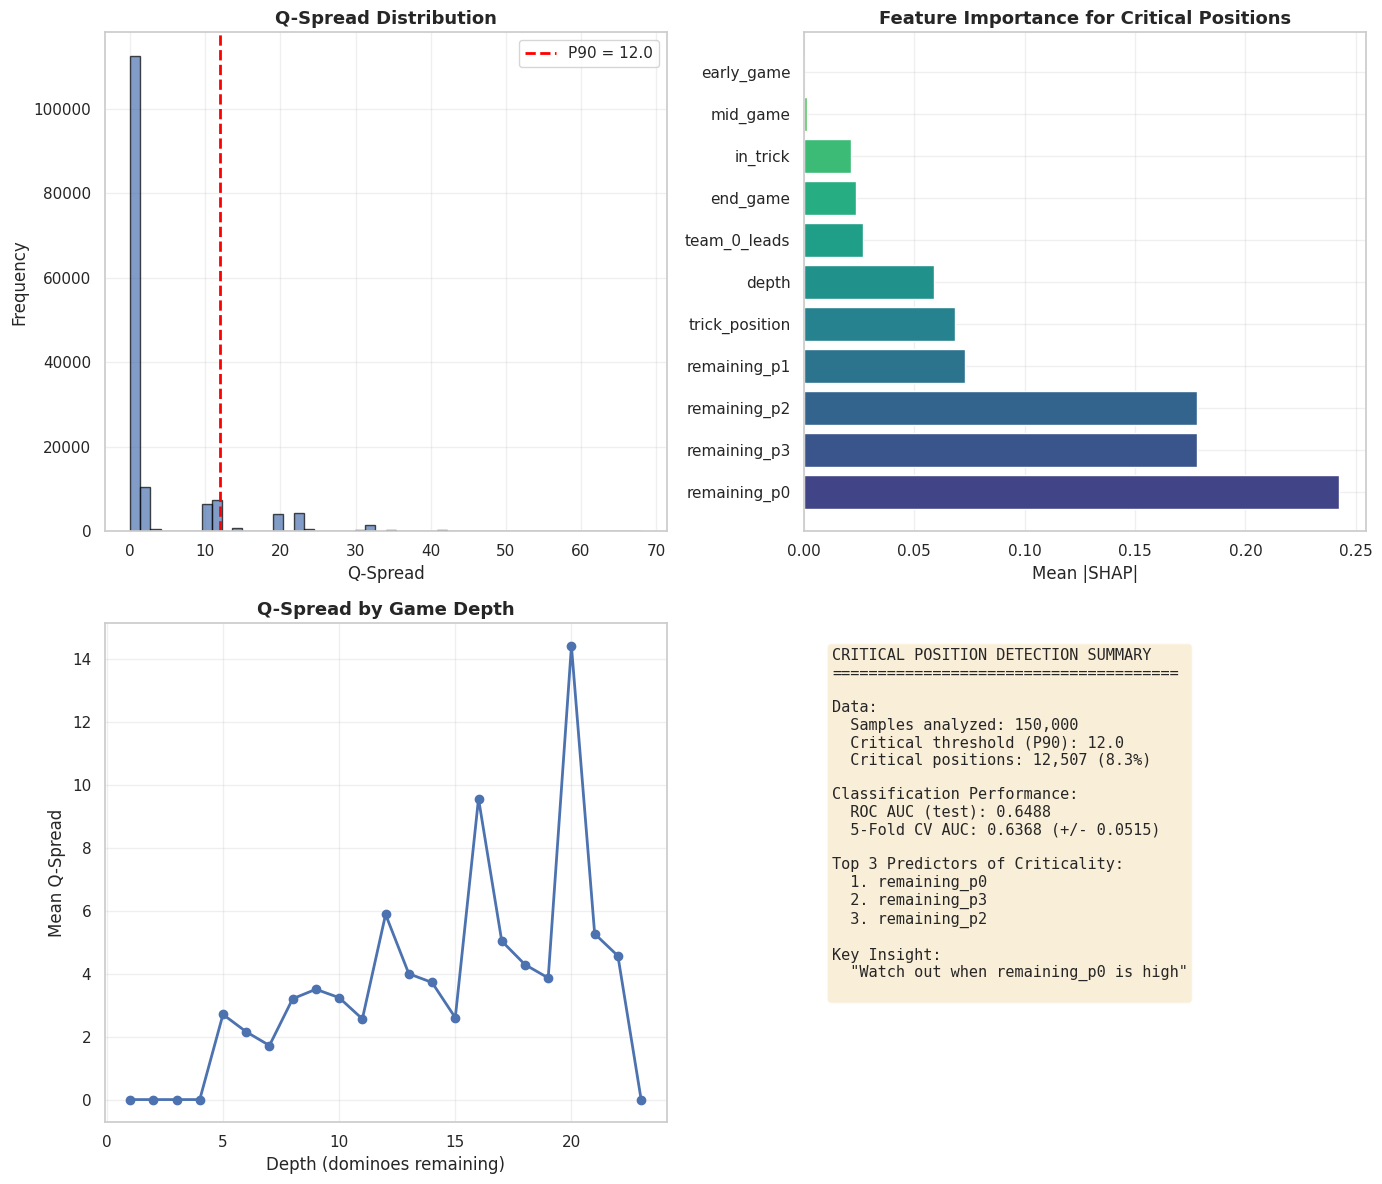

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Q-spread distribution
ax = axes[0, 0]
ax.hist(df['q_spread'], bins=50, alpha=0.7, edgecolor='black')
ax.axvline(threshold_90, color='red', linestyle='--', linewidth=2, 
           label=f'P90 = {threshold_90:.1f}')
ax.set_xlabel('Q-Spread', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Q-Spread Distribution', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Feature importance bar chart
ax = axes[0, 1]
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(importance_df)))
bars = ax.barh(importance_df['feature'], importance_df['mean_shap'], color=colors)
ax.set_xlabel('Mean |SHAP|', fontsize=12)
ax.set_title('Feature Importance for Critical Positions', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Plot 3: Q-spread by depth
ax = axes[1, 0]
depth_groups = df.groupby('depth')['q_spread'].mean()
ax.plot(depth_groups.index, depth_groups.values, 'o-', markersize=6, linewidth=2)
ax.set_xlabel('Depth (dominoes remaining)', fontsize=12)
ax.set_ylabel('Mean Q-Spread', fontsize=12)
ax.set_title('Q-Spread by Game Depth', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 4: Summary
ax = axes[1, 1]
ax.axis('off')

top_features = importance_df.head(3)['feature'].tolist()
summary_text = f"""CRITICAL POSITION DETECTION SUMMARY
======================================

Data:
  Samples analyzed: {len(df):,}
  Critical threshold (P90): {threshold_90:.1f}
  Critical positions: {df['is_critical'].sum():,} ({df['is_critical'].mean()*100:.1f}%)

Classification Performance:
  ROC AUC (test): {auc_score:.4f}
  5-Fold CV AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})

Top 3 Predictors of Criticality:
  1. {top_features[0]}
  2. {top_features[1]}
  3. {top_features[2]}

Key Insight:
  "Watch out when {top_features[0]} is high"
"""

ax.text(0.05, 0.95, summary_text, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('../../results/figures/25f_critical_positions.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Save Results

In [12]:
# Create results DataFrame
results = {
    'metric': ['n_samples', 'critical_threshold_p90', 'n_critical', 'critical_rate',
               'roc_auc_test', 'roc_auc_cv_mean', 'roc_auc_cv_std',
               'top_feature_1', 'top_shap_1',
               'top_feature_2', 'top_shap_2',
               'top_feature_3', 'top_shap_3'],
    'value': [len(df), threshold_90, df['is_critical'].sum(), df['is_critical'].mean(),
              auc_score, cv_scores.mean(), cv_scores.std(),
              importance_df.iloc[0]['feature'], importance_df.iloc[0]['mean_shap'],
              importance_df.iloc[1]['feature'], importance_df.iloc[1]['mean_shap'],
              importance_df.iloc[2]['feature'], importance_df.iloc[2]['mean_shap']]
}
results_df = pd.DataFrame(results)

# Save
output_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/25f_critical_positions.csv"
results_df.to_csv(output_path, index=False)
print(f"Saved to {output_path}")

# Also save feature importance table
importance_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/25f_feature_importance.csv"
importance_df.to_csv(importance_path, index=False)
print(f"Saved feature importance to {importance_path}")

Saved to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/25f_critical_positions.csv
Saved feature importance to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/25f_feature_importance.csv


## Key Findings

In [13]:
print("\n" + "="*60)
print("KEY INSIGHTS: Critical Position Detection")
print("="*60)

print(f"\n1. QUESTION:")
print("   When should you think hard vs play fast?")

print(f"\n2. DATA:")
print(f"   Samples analyzed: {len(df):,}")
print(f"   Critical threshold (Q-spread > P90): {threshold_90:.1f}")

print(f"\n3. MODEL PERFORMANCE:")
print(f"   ROC AUC: {auc_score:.4f}")
print(f"   CV AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")

print(f"\n4. TOP PREDICTORS OF CRITICALITY:")
for i, (_, row) in enumerate(importance_df.head(5).iterrows(), 1):
    print(f"   {i}. {row['feature']}: SHAP = {row['mean_shap']:.4f}")

print(f"\n5. TAKEAWAY:")
print(f"   'Watch out when {importance_df.iloc[0]["feature"]} is {"high" if importance_df.iloc[0]["feature"] in ["depth", "q_spread"] else "unusual"}!'")


KEY INSIGHTS: Critical Position Detection

1. QUESTION:
   When should you think hard vs play fast?

2. DATA:
   Samples analyzed: 150,000
   Critical threshold (Q-spread > P90): 12.0

3. MODEL PERFORMANCE:
   ROC AUC: 0.6488
   CV AUC: 0.6368 (+/- 0.0515)

4. TOP PREDICTORS OF CRITICALITY:
   1. remaining_p0: SHAP = 0.2424
   2. remaining_p3: SHAP = 0.1779
   3. remaining_p2: SHAP = 0.1779
   4. remaining_p1: SHAP = 0.0732
   5. trick_position: SHAP = 0.0686

5. TAKEAWAY:
   'Watch out when remaining_p0 is unusual!'


## Summary

### Goal: Identify when positions are "critical" (high Q-spread)

**Result**: [Populated by notebook execution]

### Interpretation

Q-spread = max(Q) - min(Q) measures how much the best and worst moves differ.
High Q-spread means the decision matters a lot; low Q-spread means most moves are similar.

Critical positions (Q-spread > 90th percentile) are where you should think carefully.
The SHAP analysis reveals which game features predict these pivotal moments.

### Output Files

- `results/tables/25f_critical_positions.csv` - Summary statistics
- `results/tables/25f_feature_importance.csv` - Full feature ranking
- `results/figures/25f_critical_positions.png` - 4-panel visualization